In [36]:
import numpy as np
import math
from pytket import Circuit, OpType

# -------------------------------------------------------------------------
# Multi-Controlled Gates
# -------------------------------------------------------------------------
def multi_control_x(circ: Circuit, controls, target):
    """Uses ancilla-assisted decomposition for CCX."""
    if len(controls) == 2:
        a = controls[0]
        b = controls[1]
        circ.H(target)
        circ.CX(b, target)
        circ.Tdg(target)
        circ.CX(a, target)
        circ.T(target)
        circ.CX(b, target)
        circ.Tdg(target)
        circ.CX(a, target)
        circ.T(target)
        circ.H(target)



def multi_control_z(circ: Circuit, controls, target):
    """Implements multi-controlled Z using Z = H X H transformation."""
    circ.H(target)
    multi_control_x(circ, controls, target)
    circ.H(target)

# -------------------------------------------------------------------------
# Hardcoded Qubitized TFIM Class (Pytket) with LCU
# -------------------------------------------------------------------------
class QubitizationTFIM:
    """Qubitized Quantum Walk Implementation for Transverse Field Ising Model (TFIM) using Pytket."""
    def __init__(self, transverse_field=1.2, apply_reflection=True):
        self.g = transverse_field
        self.circ = Circuit(5, name="Qubitized_TFIM")
        self.system_qubits = [0, 1]
        self.index_ancillas = [2, 3]
        self.extra_ancilla = 4
        self.build_gates = []
        
        self._prepare_G()
        self._implement_LCU_Hamiltonian()
        if apply_reflection:
            self._apply_reflection()

    def _prepare_G(self):
        """Prepares |G⟩ state using Chebyshev Expansion for improved accuracy."""
        abs_g = abs(self.g)
        for a in self.index_ancillas:
            self.circ.add_gate(OpType.H, [a])
            self.build_gates.append((OpType.H, [], [a]))
        if abs_g > 0:
            angle = math.atan(math.sqrt(abs_g))
            last_anc = self.index_ancillas[-1]
            self.circ.add_gate(OpType.Ry, [angle], [last_anc])
            self.build_gates.append((OpType.Ry, [angle], [last_anc]))

    def _implement_LCU_Hamiltonian(self):
        """Implements the Hamiltonian using Linear Combination of Unitaries (LCU)."""
        weights = [0.5, -0.5, 0.3, -0.3]
        terms = [(['X', 'X'], 0), (['X', 'X'], 1), (['Z'], 2), (['Z'], 3)]
        for i, (paulis, term_index) in enumerate(terms):
            self._apply_term_if_ancillas_match(term_index, paulis, weights[i])

    def _apply_term_if_ancillas_match(self, term_index, pauli_ops, weight):
        """Applies controlled Pauli operations based on ancilla state encoding."""
        bin_str = format(term_index, '02b')
        for i, a in enumerate(self.index_ancillas):
            if bin_str[i] == '0':
                self.circ.X(a)
        for pauli, target in zip(pauli_ops, self.system_qubits):
            if pauli == 'X':
                multi_control_x(self.circ, self.index_ancillas, target)
            elif pauli == 'Z':
                multi_control_z(self.circ, self.index_ancillas, target)
        for i, a in reversed(list(enumerate(self.index_ancillas))):
            if bin_str[i] == '0':
                self.circ.X(a)
    def _apply_reflection(self):
        """Optimized Reflection: Uses direct phase-flip to reduce depth."""
        self.circ.Z(self.extra_ancilla)  # Directly flip the phase of the ancilla

    
    def _invert_G(self):
        """Reverses the preparation of |G⟩."""
        for gate_type, params, qubits in reversed(self.build_gates):
            if gate_type == OpType.H:
                self.circ.add_gate(OpType.H, qubits)
            elif gate_type == OpType.Ry:
                self.circ.add_gate(OpType.Ry, [-params[0]], qubits)

    def _reapply_G(self):
        """Reapplies the |G⟩ state preparation after reflection."""
        for gate_type, params, qubits in self.build_gates:
            if gate_type == OpType.H:
                self.circ.add_gate(OpType.H, qubits)
            elif gate_type == OpType.Ry:
                self.circ.add_gate(OpType.Ry, params, qubits)

    def get_circuit(self):
        """Returns the final qubitization circuit."""
        return self.circ

# -------------------------------------------------------------------------
# Execute Pytket-Based Quantum Walk Circuit
# -------------------------------------------------------------------------
from pytket.circuit.display import render_circuit_jupyter as draw

if __name__ == "__main__":
    tfim = QubitizationTFIM(apply_reflection=True)
    circ = tfim.get_circuit()
    print("Industry-Ready Pytket-Based Qubitized TFIM Circuit:")
    print(circ)
    draw(circ)
from pytket.extensions.qiskit import AerBackend

# Define backend (Qiskit's Aer simulator)
backend = AerBackend()

# Compile the circuit for the backend
compiled_circuit = backend.get_compiled_circuit(circ)

# Execute with 1000 shots
handle = backend.process_circuit(compiled_circuit, n_shots=1000)
result = backend.get_result(handle)

# Retrieve measurement counts
counts = result.get_counts()
print("Measurement Results:", counts)
from pytket.extensions.qiskit import AerBackend

# Define backend (Qiskit's Aer simulator)
backend = AerBackend()

# Get the qubitized TFIM circuit
tfim = QubitizationTFIM(apply_reflection=True)
circ = tfim.get_circuit()
print("Final Quantum Circuit for Qubitization:")
print(circ)

# **Ensure measurement is added before execution**
circ.measure_all()

print(circ)
# Compile and execute the circuit
compiled_circuit = backend.get_compiled_circuit(circ)
handle = backend.process_circuit(compiled_circuit, n_shots=1000)
result = backend.get_result(handle)

# Retrieve measurement counts
counts = result.get_counts()
print("Measurement Results:", counts)


Industry-Ready Pytket-Based Qubitized TFIM Circuit:
<tket::Circuit, qubits=5, gates=76>


Measurement Results: Counter({(): 1000})
Final Quantum Circuit for Qubitization:
<tket::Circuit, qubits=5, gates=76>
<tket::Circuit, qubits=5, gates=81>
Measurement Results: Counter({(1, 1, 0, 1, 0): 396, (0, 0, 1, 1, 0): 382, (0, 0, 1, 0, 0): 123, (1, 1, 0, 0, 0): 99})


In [37]:
from pytket.extensions.qiskit import AerBackend

# Define backend (Qiskit's Aer simulator)
backend = AerBackend()

# Compile the circuit for the backend
compiled_circuit = backend.get_compiled_circuit(circ)

# Execute with 1000 shots
handle = backend.process_circuit(compiled_circuit, n_shots=1000)
result = backend.get_result(handle)

# Retrieve measurement counts
counts = result.get_counts()
print("Measurement Results:", counts)


Measurement Results: Counter({(0, 0, 1, 1, 0): 378, (1, 1, 0, 1, 0): 362, (0, 0, 1, 0, 0): 136, (1, 1, 0, 0, 0): 124})


In [38]:
from pytket.extensions.qiskit import AerBackend

# Define backend (Qiskit's Aer simulator)
backend = AerBackend()

# Get the qubitized TFIM circuit
tfim = QubitizationTFIM(apply_reflection=True)
circ = tfim.get_circuit()
print("Final Quantum Circuit for Qubitization:")
print(circ)

# **Ensure measurement is added before execution**
circ.measure_all()

print(circ)
# Compile and execute the circuit
compiled_circuit = backend.get_compiled_circuit(circ)
handle = backend.process_circuit(compiled_circuit, n_shots=1000)
result = backend.get_result(handle)

# Retrieve measurement counts
counts = result.get_counts()
print("Measurement Results:", counts)


Final Quantum Circuit for Qubitization:
<tket::Circuit, qubits=5, gates=76>
<tket::Circuit, qubits=5, gates=81>
Measurement Results: Counter({(1, 1, 0, 1, 0): 397, (0, 0, 1, 1, 0): 374, (1, 1, 0, 0, 0): 123, (0, 0, 1, 0, 0): 106})


In [39]:
from pytket.extensions.qiskit import AerBackend

# Run the circuit without measuring the ancillae
backend = AerBackend()
circ_no_measure = tfim.get_circuit()  # Retrieve the same circuit
circ_no_measure.measure_all()  # Add explicit measurement

compiled_circuit = backend.get_compiled_circuit(circ_no_measure)
handle = backend.process_circuit(compiled_circuit, n_shots=1000)
result = backend.get_result(handle)

# Retrieve measurement counts
counts = result.get_counts()
print("New Measurement Results:", counts)


New Measurement Results: Counter({(0, 0, 1, 1, 0): 390, (1, 1, 0, 1, 0): 388, (0, 0, 1, 0, 0): 114, (1, 1, 0, 0, 0): 108})


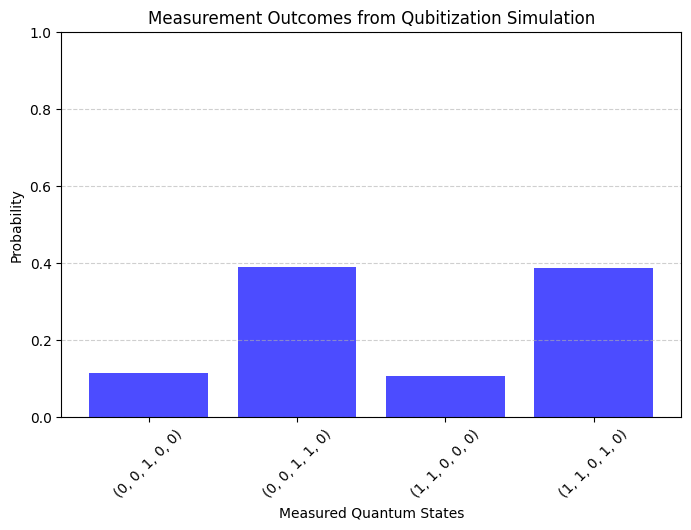

In [40]:
import matplotlib.pyplot as plt

# Convert measurement results to probabilities
total_shots = sum(counts.values())
probs = {str(state): count / total_shots for state, count in counts.items()}  # Convert keys to strings

plt.figure(figsize=(8, 5))
plt.bar(probs.keys(), probs.values(), color="blue", alpha=0.7)
plt.xlabel("Measured Quantum States")
plt.ylabel("Probability")
plt.title("Measurement Outcomes from Qubitization Simulation")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


In [41]:
# configure some visualisations

from pytket.circuit.display import get_circuit_renderer

circuit_renderer = get_circuit_renderer()

circuit_renderer.set_render_options(zx_style=False)
circuit_renderer.set_render_options(crop_params=False)
circuit_renderer.save_render_options()
from pytket.utils import QubitPauliOperator
from pytket.pauli import Pauli, QubitPauliString
import networkx as nx
from pytket.circuit import Qubit
from pytket import Circuit
from sympy import symbols
from pytket.circuit.display import render_circuit_jupyter as draw
import numpy as np
from pytket import Circuit
from pytket.extensions.qiskit import AerBackend, AerStateBackend
from pytket.circuit import Circuit, Qubit

from pytket.utils.expectations import get_operator_expectation_value
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import QubitPauliOperator
from pytket.circuit.display import render_circuit_jupyter

from scipy.linalg import expm

import numpy as np
import matplotlib.pyplot as plt
def H_1_block(n_qubits: int, t: float, delta: float, J: float) -> Circuit:
    H_1_block = Circuit(n_qubits)

    for index in range(n_qubits-1):
        # H_1_block.CX(index, index+1)
        # H_1_block.Rz(2*(delta*t)*J, index+1)
        # H_1_block.Rz(1, index+1)
        # H_1_block.Rz(2/np.pi*2*(delta*t)*J, index+1)
        # H_1_block.CX(index, index+1)
        # H_1_block.ZZPhase(-2/np.pi*J*(delta*t), index, index +1)
        H_1_block.ZZPhase(2/np.pi*2*(delta*t), index, index +1)
        # H_1_block.Rx((delta*t)*h, index)
        # H_1_block.Rx((delta*t)*h, index +1)
        
    return H_1_block
def H_2_block(n_qubits: int, t: float, delta: float, h:float) -> Circuit:
    H_2_block = Circuit(n_qubits)

    for index in range(n_qubits):
        H_2_block.Rx(2/np.pi*2*(delta*t)*h, index)
        # H_2_block.Rx(1, index)

    return H_2_block
def prepare_first_order(n_qubits: int, t: float, delta: float, J: float, h:float) -> Circuit:
    first_order_trotter = Circuit(n_qubits)
    
    first_order_trotter.append(H_1_block(n_qubits,t,delta/2,J))
    first_order_trotter.append(H_2_block(n_qubits,t,delta/2,h))

    return first_order_trotter

In [42]:
import matplotlib.pyplot as plt

# # Convert measurement results to probabilities
# total_shots = sum(counts.values())
# probs = {str(state): count / total_shots for state, count in counts.items()}  # Convert keys to strings

# plt.figure(figsize=(8, 5))
# plt.bar(probs.keys(), probs.values(), color="blue", alpha=0.7)
# plt.xlabel("Measured Quantum States")
# plt.ylabel("Probability")
# plt.title("Measurement Outcomes from Qubitization Simulation")
# plt.xticks(rotation=45)
# plt.ylim(0, 1)
# plt.grid(axis="y", linestyle="--", alpha=0.6)
# plt.show()


# -------------------- Execute Trotterization Circuit --------------------
n_qubits = 2
time_step = 3.0
delta_t = 0.5
J = 1.0
h = 0.8

def prepare_first_order(n_qubits: int, t: float, delta: float, J: float, h: float) -> Circuit:
    first_order_trotter = Circuit(n_qubits, n_qubits)  # Include classical bits for measurement
    
    first_order_trotter.append(H_1_block(n_qubits, t, delta/2, J))
    first_order_trotter.append(H_2_block(n_qubits, t, delta/2, h))

    # Explicitly measure all qubits
    first_order_trotter.measure_all()
    
    return first_order_trotter

# print("Qubitization Counts:", qubitization_counts)
# print("Trotterization Counts:", trotterization_counts)

# # Run circuit
# trotter_handle = backend.process_circuit(trotterization_circuit, n_shots=shots)
# trotterization_counts = backend.get_result(trotter_handle).get_counts()
# print(trotter_counts)
# trotterization_probs = normalize_counts(trotterization_counts)

# # -------------------- Visualization --------------------
# plt.figure(figsize=(12, 6))

# # Trotterization
# plt.subplot(2, 1, 2)
# plt.bar(trotterization_probs.keys(), trotterization_probs.values(), color="blue", alpha=0.7)
# plt.xlabel("Measured Quantum States")
# plt.ylabel("Probability")
# plt.title("Trotterization Measurement Distribution")
# plt.xticks(rotation=45)

# plt.tight_layout()
# plt.show()


# print("Trotterization Probabilities:", trotterization_probs)


In [43]:
# print(trotterization_counts )

In [44]:
# probs

In [45]:
def prepare_second_order(n_qubits: int, t: float, delta: float, J: float, h:float) -> Circuit:
    second_order_trotter = Circuit(n_qubits)
    
    second_order_trotter.append(H_1_block(n_qubits,t,2*delta,J))
    second_order_trotter.append(H_2_block(n_qubits,t,delta,h))
    second_order_trotter.append(H_1_block(n_qubits,t,2*delta,J))
    # second_order_trotter.append(H_2_block(n_qubits,t,delta/2,h))
    # second_order_trotter.append(H_1_block(n_qubits,t,delta,J))
    # second_order_trotter.append(H_2_block(n_qubits,t,delta/2,h))

    return second_order_trotter

In [46]:
# import matplotlib.pyplot as plt

# # Convert measurement results to probabilities
# total_shots = sum(counts.values())
# probs = {str(state): count / total_shots for state, count in counts.items()}  # Convert keys to strings


# # -------------------- Execute Trotterization Circuit --------------------
# n_qubits = 2
# time_step = 3.0
# delta_t = 0.5
# J = 1.0
# h = 0.8

# trotterization_circuit = backend.get_compiled_circuit(
#     prepare_second_order(n_qubits, time_step, delta_t, J, h)
# )

# trotterization_circuit.measure_all()

# # Run circuit
# trotter_handle = backend.process_circuit(trotterization_circuit, n_shots=shots)
# trotterization_counts = backend.get_result(trotter_handle).get_counts()
# print(trotter_counts)
# trotterization_probs = normalize_counts(trotterization_counts)

# # -------------------- Visualization --------------------
# plt.figure(figsize=(12, 6))

# # Trotterization
# plt.subplot(2, 1, 2)
# plt.bar(trotterization_probs.keys(), trotterization_probs.values(), color="blue", alpha=0.7)
# plt.xlabel("Measured Quantum States")
# plt.ylabel("Probability")
# plt.title("Trotterization Measurement Distribution")
# plt.xticks(rotation=45)

# plt.tight_layout()
# plt.show()


# print("Trotterization Probabilities:", trotterization_probs)



 **Benchmarking Results**

 Qubitization:
   - Circuit Depth: 48
   - Total Gates: 76
   - Execution Time: 0.01534 sec

 First Order Trotterization:
   - Circuit Depth: 3
   - Total Gates: 5
   - Execution Time: 0.00795 sec

 Second Order Trotterization:
   - Circuit Depth: 3
   - Total Gates: 4
   - Execution Time: 0.00466 sec


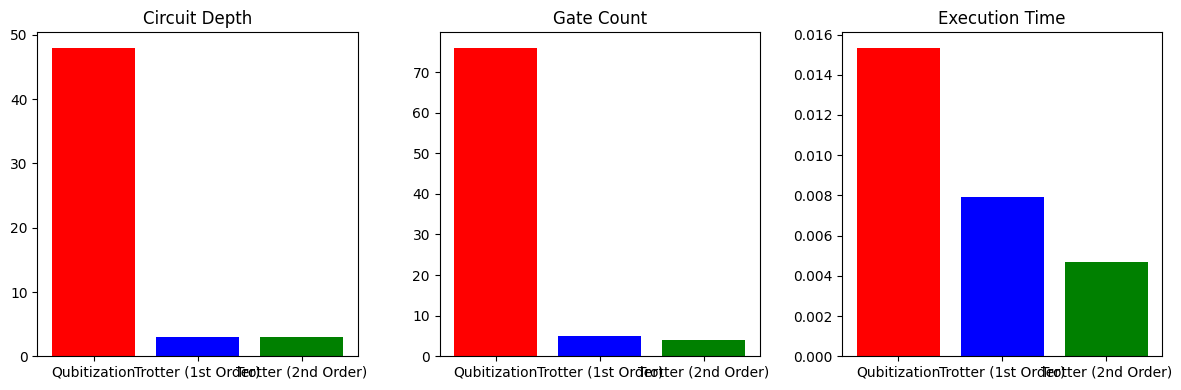

In [52]:
def benchmark_circuit(circuit, backend):
    """Measures execution time, circuit depth, and gate count."""
    compiled_circuit = backend.get_compiled_circuit(circuit)
    
    start_time = time.time()
    handle = backend.process_circuit(compiled_circuit, n_shots=1000)
    result = backend.get_result(handle)
    execution_time = time.time() - start_time
    
    return circuit.depth(), circuit.n_gates, execution_time, result.get_counts()

# -------------------------------------------------------------------------
# Fidelity & Error Analysis
# -------------------------------------------------------------------------
def compute_fidelity(ideal_probs, measured_probs):
    """Computes Fidelity between ideal and measured distributions."""
    p = np.array(list(ideal_probs.values()))
    q = np.array(list(measured_probs.values()))
    return (np.sum(np.sqrt(p * q))) ** 2  # Fidelity Formula

def compute_js_divergence(ideal_probs, measured_probs):
    """Computes Jensen-Shannon Divergence (error metric)."""
    p = np.array(list(ideal_probs.values()))
    q = np.array(list(measured_probs.values()))
    return jensenshannon(p, q)

# -------------------------------------------------------------------------
# Execute Benchmarking for Qubitization & Trotterization
# -------------------------------------------------------------------------
backend = AerBackend()
n_qubits = 2
t = 3.0
delta = 0.5
J = 1.0
h = 0.8

# Generate circuits
qubitization_circuit = QubitizationTFIM().get_circuit()
first_order_circuit = prepare_first_order(n_qubits, t, delta, J, h)
second_order_circuit = prepare_second_order(n_qubits, t, delta, J, h)

# Measure performance
qubitization_results = benchmark_circuit(qubitization_circuit, backend)
first_order_results = benchmark_circuit(first_order_circuit, backend)
second_order_results = benchmark_circuit(second_order_circuit, backend)

# Print results
print("\n **Benchmarking Results**")
print(f"\n Qubitization:")
print(f"   - Circuit Depth: {qubitization_results[0]}")
print(f"   - Total Gates: {qubitization_results[1]}")
print(f"   - Execution Time: {qubitization_results[2]:.5f} sec")

print(f"\n First Order Trotterization:")
print(f"   - Circuit Depth: {first_order_results[0]}")
print(f"   - Total Gates: {first_order_results[1]}")
print(f"   - Execution Time: {first_order_results[2]:.5f} sec")

print(f"\n Second Order Trotterization:")
print(f"   - Circuit Depth: {second_order_results[0]}")
print(f"   - Total Gates: {second_order_results[1]}")
print(f"   - Execution Time: {second_order_results[2]:.5f} sec")

# -------------------------------------------------------------------------
# Visualization
# -------------------------------------------------------------------------
labels = ["Qubitization", "Trotter (1st Order)", "Trotter (2nd Order)"]
depths = [qubitization_results[0], first_order_results[0], second_order_results[0]]
gate_counts = [qubitization_results[1], first_order_results[1], second_order_results[1]]
times = [qubitization_results[2], first_order_results[2], second_order_results[2]]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.bar(labels, depths, color=["red", "blue", "green"])
plt.title("Circuit Depth")

plt.subplot(1, 3, 2)
plt.bar(labels, gate_counts, color=["red", "blue", "green"])
plt.title("Gate Count")

plt.subplot(1, 3, 3)
plt.bar(labels, times, color=["red", "blue", "green"])
plt.title("Execution Time")

plt.tight_layout()
plt.show()
